In [1]:
from skimage import feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
import xgboost as XGB

In [2]:
parent_folder = Path().resolve().parent
src_path = parent_folder / 'src'
sys.path.append(str(src_path))
from tools import get_embedding_pyAudio, get_embedding_birdnet

In [3]:
parent_folder = Path().resolve().parent.parent
sys.path.append(str(parent_folder))
from pyAudioAnalysis import MidTermFeatures as mT 

C:\Users\dgnhk\anaconda3\envs\clef\Lib\site-packages\pyAudioAnalysis\..\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Combine BirdNet embeddings and pyAudioAnalysis embeddings

In [4]:
root_folder='C:/Users/dgnhk/Woodcock-CNN/data/train_data/embedding/'
audio_folder='C:/Users/dgnhk/Woodcock-CNN/data/train_data/audio/'

In [5]:
# Sample line for extracting features
#mT.mid_feature_extraction_file_dir(audio_folder+'1/', 3.0, 3.0, 0.2, 0.2)
#mT.mid_feature_extraction_file_dir(audio_folder+'0/', 3.0, 3.0, 0.2, 0.2)

In [6]:
pos_embeddings_birdnet = get_embedding_birdnet(root_folder, 1)
neg_embeddings_birdnet = get_embedding_birdnet(root_folder, 0)

In [7]:
pos_embeddings = get_embedding_pyAudio(audio_folder, 1)
neg_embeddings = get_embedding_pyAudio(audio_folder, 0)


In [8]:
df_pos = pd.DataFrame(data=pos_embeddings)
df_neg = pd.DataFrame(data=neg_embeddings)

df_pos_bnet = pd.DataFrame(data=pos_embeddings_birdnet)
df_neg_bnet = pd.DataFrame(data=neg_embeddings_birdnet)


df_pos_comb = pd.concat([df_pos, df_pos_bnet], ignore_index=True, axis=1)
df_neg_comb = pd.concat([df_neg, df_neg_bnet], ignore_index=True, axis=1)


In [9]:
df_neg_comb['target'] = 0
df_pos_comb['target'] = 1

In [47]:
df_combined = pd.concat([df_pos_comb, df_neg_comb.sample(1000, random_state=21)], ignore_index=True, axis=0)
df_combined = df_combined.sample(frac=1, random_state=42)

In [48]:
#Generate Test and Train datasets
X = df_combined.iloc[:, :-1] #All values except the last column
y = df_combined.iloc[:, -1] #All values from the last column

train, test, train_target, test_target = train_test_split(X, y, test_size=0.20, random_state=42)

In [49]:
class Config:
    oversample = True
    undersample = False

oversampler = SMOTE()
undersampler = RandomUnderSampler()

if Config.oversample:
    train, train_target = oversampler.fit_resample(train, train_target)
elif Config.undersample:
    train, train_target = undersampler.fit_resample(train, train_target)
else: 
    print("Using the original dataset")

SVM

In [50]:
model = SVC(cache_size=500, kernel='rbf')
model.fit(train,train_target)

SVC(cache_size=500)

Test set average precision: 0.8448462998748606
              precision    recall  f1-score   support

           0     0.7913    0.9838    0.8771       185
           1     0.9773    0.7288    0.8350       177

    accuracy                         0.8591       362
   macro avg     0.8843    0.8563    0.8560       362
weighted avg     0.8822    0.8591    0.8565       362



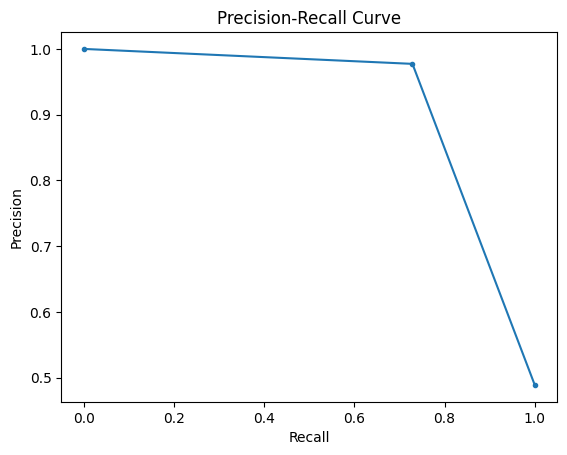

In [51]:
predictions = model.predict(test)
ap = average_precision_score(test_target, predictions)
print("Test set average precision:", ap)

report=classification_report(test_target, predictions, digits=4)
print(report)

# Only for binary classification (adjust for multi-class)
precision, recall, thr = precision_recall_curve(test_target, predictions)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Random Forest

In [52]:
model = RFC(n_jobs = -1)
model.fit(train,train_target)

RandomForestClassifier(n_jobs=-1)

Test set average precision: 0.8531692995125901
              precision    recall  f1-score   support

           0     0.7957    0.9892    0.8819       185
           1     0.9848    0.7345    0.8414       177

    accuracy                         0.8646       362
   macro avg     0.8903    0.8618    0.8617       362
weighted avg     0.8882    0.8646    0.8621       362



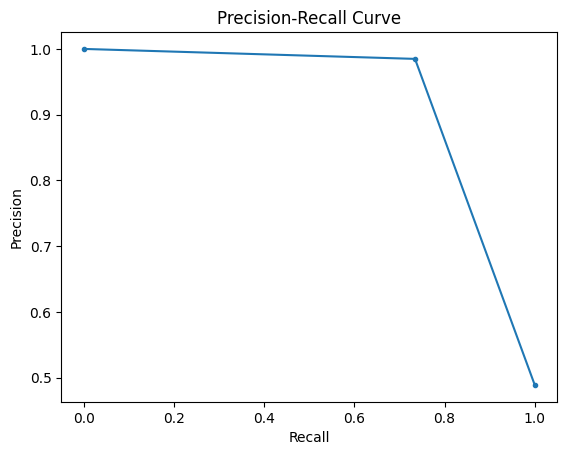

In [53]:
predictions = model.predict(test)
ap = average_precision_score(test_target, predictions)
print("Test set average precision:", ap)

report=classification_report(test_target, predictions, digits=4)
print(report)

# Only for binary classification (adjust for multi-class)
precision, recall, thr = precision_recall_curve(test_target, predictions)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

XGBoost

In [54]:
model = XGB.XGBClassifier(objective='binary:logistic')
model.fit(train,train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Test set average precision: 0.81674235478178
              precision    recall  f1-score   support

           0     0.7892    0.9514    0.8627       185
           1     0.9353    0.7345    0.8228       177

    accuracy                         0.8453       362
   macro avg     0.8622    0.8429    0.8428       362
weighted avg     0.8606    0.8453    0.8432       362



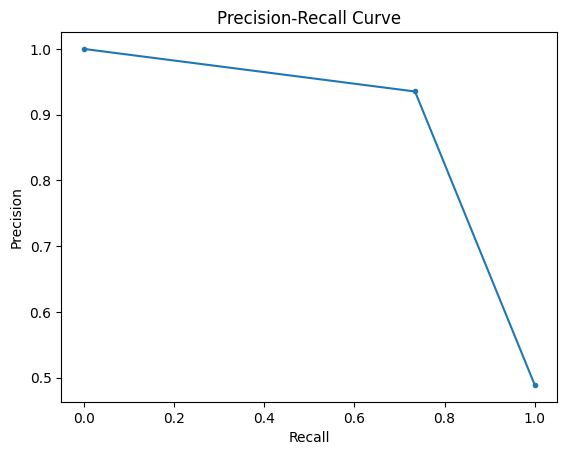

In [55]:
predictions = model.predict(test)
ap = average_precision_score(test_target, predictions)
print("Test set average precision:", ap)

report=classification_report(test_target, predictions, digits=4)
print(report)

# Only for binary classification (adjust for multi-class)
precision, recall, thr = precision_recall_curve(test_target, predictions)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()